In [1]:
import sys
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
from matplotlib_scalebar.scalebar import ScaleBar
import glob
import matplotlib.pyplot as plt

from st_utils import df_2_gdf, get_qced_cell_id
from constants import SAMPLES, PIXEL_TO_UM

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
wd = os.getcwd()
print (f'working directory: {wd}')

working directory: /home/jupyter/iST_Platform_Comparison/edit


In [2]:
def load_parquet(sample):

    if 'xenium' in sample: 

        df_b = pd.read_parquet(f'{wd}/data/{sample}/cell_boundaries.parquet')
        for col in df_b.select_dtypes(include=['object']).columns:
            df_b[col] = df_b[col].str.decode('utf-8')

        grouped = df_b.groupby('cell_id')
        cell_ids = []
        polygons = []

        # Iterate over each group (cell_id)
        for cell_id, group in grouped:
            polygon = Polygon(zip(group['vertex_y'], group['vertex_x']))
            polygons.append(polygon)
            cell_ids.append(cell_id)

        gdf = gpd.GeoDataFrame({'cell_id': cell_ids, 'geometry': polygons}, crs='EPSG:4326')

        df_c =pd.read_parquet(f'{wd}/data/cell_level_csv/{sample}_cell_level.parquet.gzip',
                        engine='pyarrow')[['cell_id','core','tissue_type']]
        gdf_join = pd.merge(gdf, df_c, on='cell_id', how='inner')

    elif 'merscope' in sample:

        gdf = gpd.GeoDataFrame()

        for i in range(len(glob.glob(f'{wd}/data/{sample}/region_*'))):
            print (f"region_{i}")
            folder = f'{wd}/data/{sample}/region_{i}'
            file = f"{folder}/cell_boundaries.parquet"
            gdf_b = gpd.read_parquet(file)
            gdf_b['EntityID'] = gdf_b['EntityID'].apply(lambda x: f"{x}_region_{i}")
            
        if gdf_b['EntityID'].duplicated().any():
            gdf = pd.concat([gdf, gdf_b],ignore_index=True)
        gdf = gdf.rename(columns={'EntityID':'cell_id'})

        mid_index = len(sorted(gdf.ZLevel.unique())) //2
        mid_num = sorted(gdf.ZLevel.unique())[mid_index]
        print(f'Mid Z level: {mid_num}')
        gdf = gdf.loc[gdf['ZLevel']==mid_num]

        gdf = gdf.explode()
        gdf['geometry'] = gdf.geometry

        # Tag core, tissue
        df_c =pd.read_parquet(f'{wd}/data/cell_level_csv/{sample}_cell_level.parquet.gzip',
                            engine='pyarrow')[['cell_id','core','tissue_type']]
        gdf_join = pd.merge(gdf, df_c, on='cell_id', how='inner')

    elif 'cosmx' in sample:
        gdf = gpd.GeoDataFrame()
        fovs = [x for x in range(1,203)] if 'htma' in sample else [x for x in range(1, 161)]
        for fov in fovs:
            try:
                fov = str(fov).zfill(3)
                parquet_file = f'{wd}/data/{sample}/segmentation_by_fov_parquet/FOV_{fov}.parquet.gzip'
                gdf_fov = gpd.read_parquet(parquet_file)
                print (fov, len(gdf_fov))
                gdf_fov['fov'] = fov
                gdf_fov['cell_id'] = gdf_fov['value'].apply(lambda x: f"c_1_{fov}_{x}")
                gdf = pd.concat([gdf, gdf_fov], ignore_index=True)
            except:
                continue

        # Tag core, tissue
        df_c =pd.read_parquet(f'{wd}/data/cell_level_csv/{sample}_cell_level.parquet.gzip',
                            engine='pyarrow')[['cell_id','core','tissue_type','fov']]

        gdf_join = pd.merge(df_c, gdf, on='cell_id', how='left')

    return gdf_join



In [4]:
gdf_all = gpd.GeoDataFrame()

for SAMPLE in SAMPLES[::2]:
    sample = SAMPLE.split('/')[1]
    print (sample)
    gdf = load_parquet(sample)
    gdf['Sample'] = sample
    gdf_all = pd.concat([gdf_all, gdf])

gdf_all.to_parquet(f'{wd}/data/all_segmentation_htma.parquet.gzip', compression='gzip', index=False)
    

xenium_breast_htma
xenium_panhuman_htma
xenium_lung_htma
merscope_breast_htma
region_0
region_1
region_2
region_3
region_4
region_5
region_6
region_7
region_8
Mid Z level: 6.0
merscope_lung_htma
region_0
region_1
region_2
region_3
region_4
Mid Z level: 4.5
cosmx_multitissue_htma
130 1617


# CosMx data due diligence

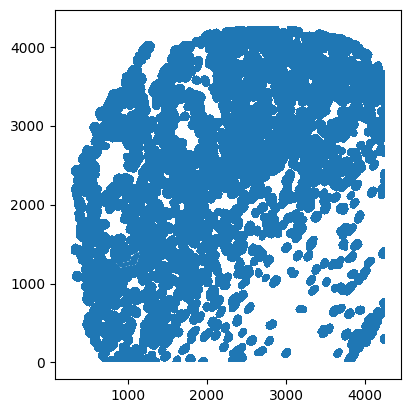

In [3]:
gdf = gpd.read_parquet('data/cosmx_multitissue_htma/segmentation_by_fov_parquet/FOV_130.parquet.gzip')
gdf.plot(aspect=1)
plt.show()

# Plot Segmentation with filtraion


before QC: 2883323
after QC using transcript count per cell: 2395233
after QC using unique genes per cell: 2395233
Good quality cells: 83.1
xenium_breast_htma
sample size of gdf_s 2115


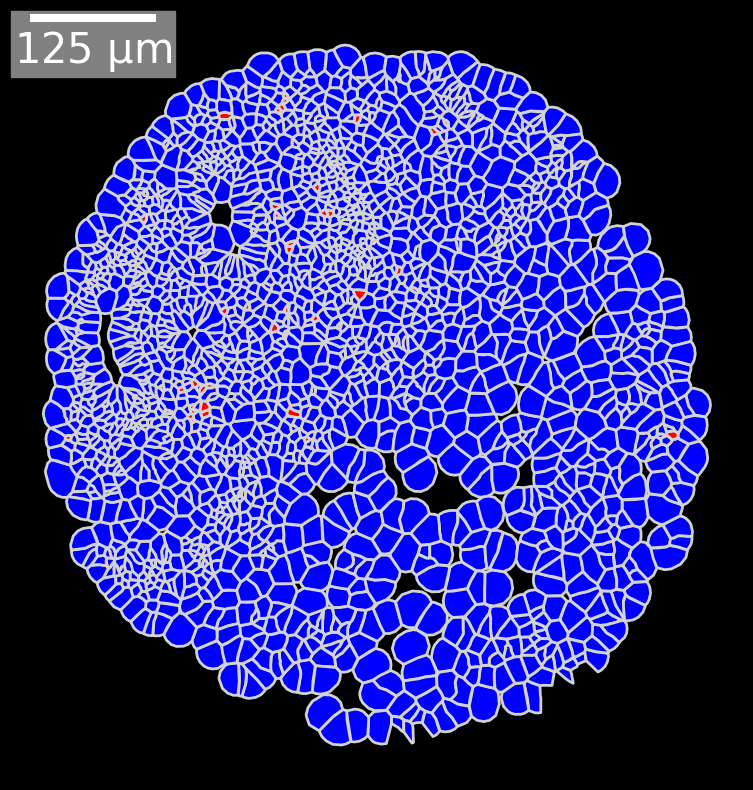

sample size of gdf_t_plot 207157


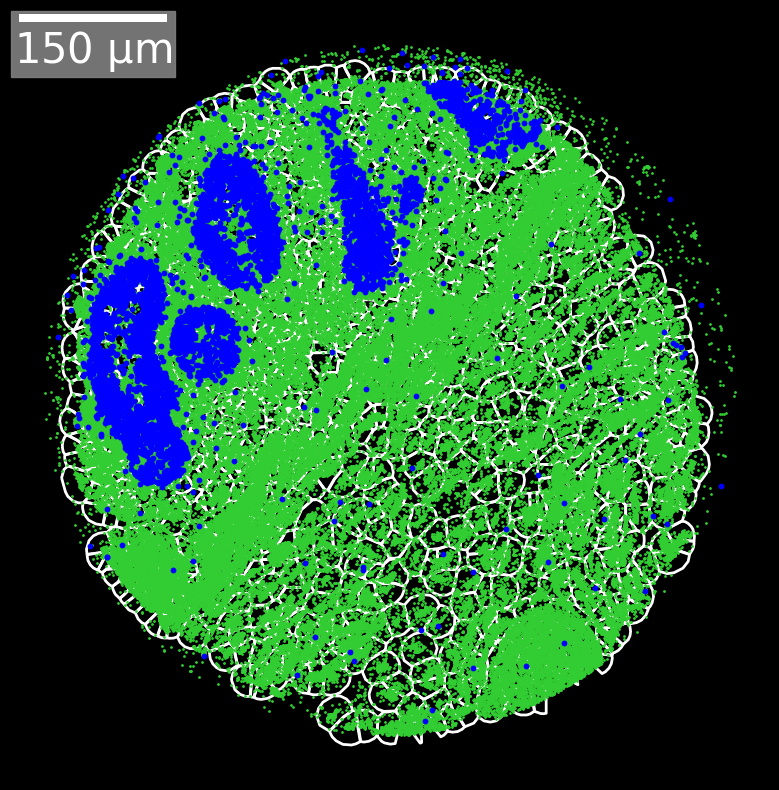

merscope_breast_htma
sample size of gdf_s 2062


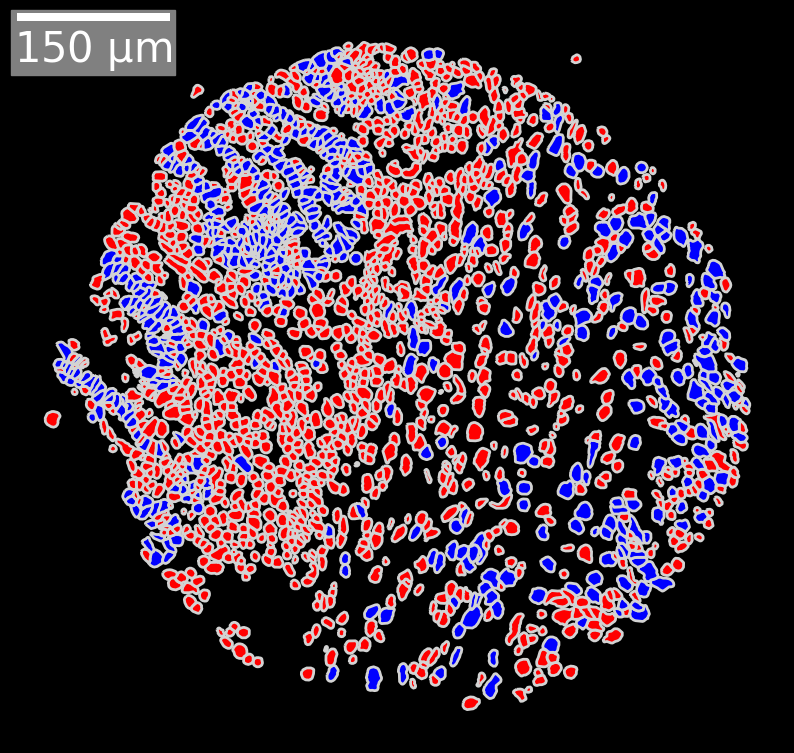

sample size of gdf_t_plot 24186


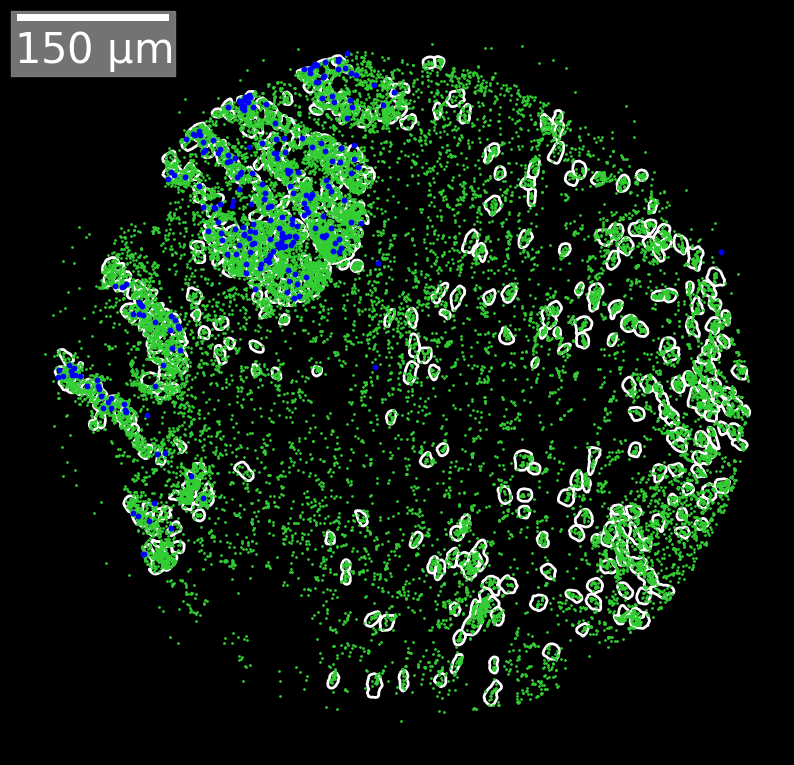

cosmx_multitissue_htma
sample size of gdf_s 1573


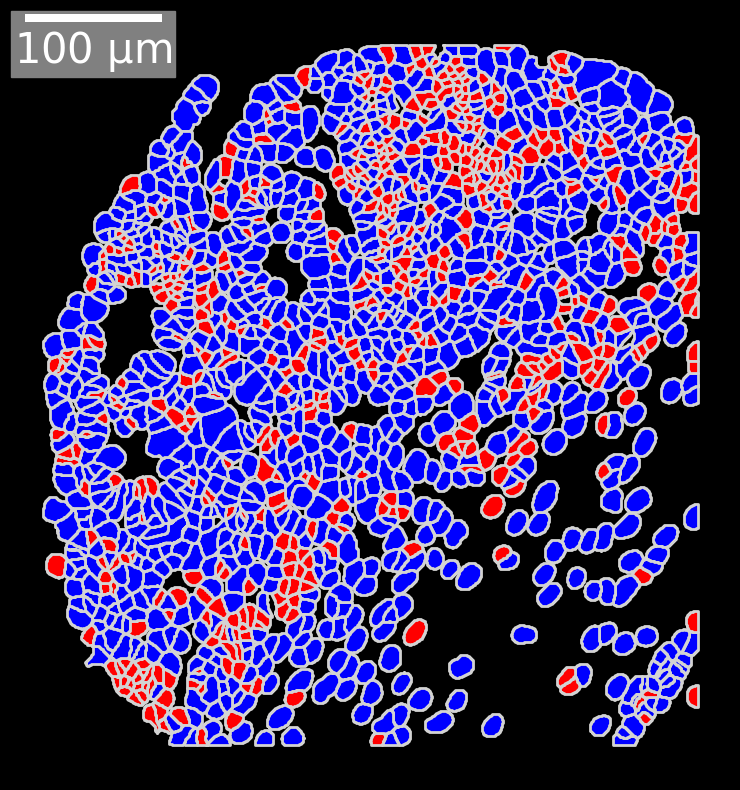

sample size of gdf_t_plot 32576


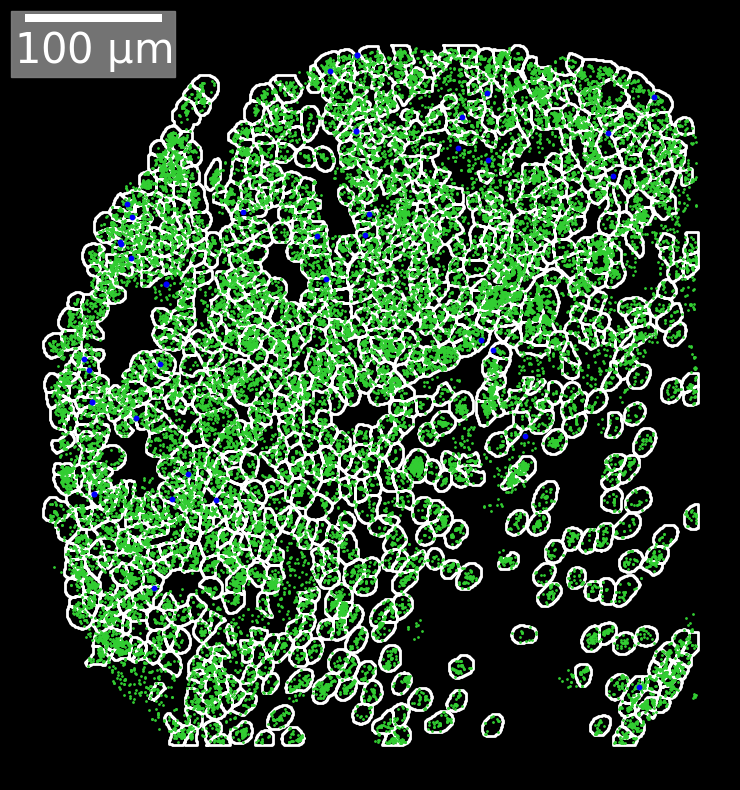

In [4]:
if not os.path.exists(f'{wd}/figures/Fig_4_Segmentation'):
    os.makedirs(f'{wd}/figures/Fig_4_Segmentation')


gdf_plot = gpd.read_parquet(f'{wd}/data/all_segmentation_htma.parquet.gzip')
only_keep = False

for core in ['31']:

    gdf_c = gdf_plot.loc[gdf_plot['core']== core]
    gdf_c['Platform'] = gdf_c['Sample'].apply(lambda x: x.split("_")[0].upper())
    gdf_c['area_sqpx'] = gdf_c['geometry'].area
    gdf_c['area_squm'] = gdf_c.apply(
        lambda row:row['area_sqpx'] * PIXEL_TO_UM[row['Platform'].lower()] * PIXEL_TO_UM[row['Platform'].lower()] if row['Platform'] == 'COSMX' else row['area_sqpx'],
        axis=1)

    metric = 'area_squm'
    ids, _ = get_qced_cell_id(10,0)
    gdf_c['Keep'] = gdf_c['cell_id'].isin(ids).map({True: 'Kept', False: 'Dropped'})
    
    for sample in ['xenium_breast_htma','merscope_breast_htma','cosmx_multitissue_htma']:
        try:
            print (sample)

            per = 0.12 if 'cosmx' in sample else 1
            gdf_s = gdf_c.loc[gdf_plot['Sample']==sample]
            print ('sample size of gdf_s',len(gdf_s))

            if 'cosmx' in sample:
                df_t = pd.read_parquet(f'{wd}/data/transcript_level_csv/{sample}_transcript_level.parquet.gzip')
                df_t_core = df_t.loc[df_t['core']==core]
                df_t_core['y_FOV_px'] = 4256 - df_t_core['y_FOV_px'] 
                gdf_t= df_2_gdf(df_t_core, 'y_FOV_px','x_FOV_px')

            else:
                gdf_t = gpd.read_parquet(f'{wd}/data/transcript_level_csv/{sample}_transcript_level.parquet.gzip')
                gdf_t = gdf_t.loc[gdf_t['core'] == core]

            gdf_t['Keep'] = gdf_t['cell_id'].isin(ids).map({True: 'Kept', False: 'Dropped'})

            # Create a figure with a blue background
            fig, ax = plt.subplots(figsize=(10, 10))
            fig.patch.set_facecolor('black')  # Set background color to blue
            gdf_s.plot('Keep', aspect=1, markersize=3, ax=ax, legend=False, edgecolor='lightgrey', cmap='bwr_r', linewidth=2.0)
            ax.add_artist(ScaleBar(per, "um", color='white', box_color='grey', 
                            box_alpha=1, location='upper left', 
                            font_properties={'size':30}))
            plt.axis('off')
            plt.show()

            fig.savefig(f'{wd}/figures/Fig_4_Segmentation/Main_Fig_4_A_keep_drop_{core}_{sample}.png', format='png', dpi=200)
#             fig.savefig(f'{wd}/figures/Fig_4_Segmentation/Main_Fig_4_A_keep_drop_{core}_{sample}.eps', format='eps', dpi=200)

            if only_keep:
                gdf_t_keep = gdf_t.loc[gdf_t['Keep']=='Kept']

            for gene in ['EPCAM','CD4','CD8A'][:1]:

                try:
                    gdf_t_plot = gdf_t.copy()
                    gdf_s_plot = gdf_s.copy()
                    if only_keep:
                        gdf_t_plot = gdf_t.loc[gdf_t['Keep']=='Kept']
                        gdf_s_plot = gdf_s.loc[gdf_s['Keep']=='Kept']


                    gdf_t_plot_gene = gdf_t_plot.loc[gdf_t_plot['gene']==gene]

                    fig, ax = plt.subplots(figsize=(10, 10))
                    fig.patch.set_facecolor('black')  # Set background color to blue

                    # All cell boundaries
                    gdf_s_plot.loc[gdf_s['Keep']=='Kept'].plot('Keep',
                                                        aspect=1,
                                                        markersize=3,
                                                        ax=ax, legend=False,
                                                        edgecolor='white',
                                                        facecolor='none',
                                                        linewidth=2.0)

                    # All transcripts
                    gdf_t_plot.plot(aspect=1, markersize=1, ax=ax, legend=False, color='limegreen')
                    print ('sample size of gdf_t_plot',len(gdf_t_plot))

                    # Specific gene
                    gdf_t_plot_gene.plot(aspect=1, markersize=10, ax=ax, legend=True, color='blue')
                    ax.add_artist(ScaleBar(per, 'um', color='white', box_color='grey', 
                                    box_alpha=0.9, location='upper left', 
                                    font_properties={'size':30}))
                    plt.axis('off')
                    plt.show()

                    fig.savefig(f'{wd}/figures/Fig_4_Segmentation/Main_Fig_4_A_{gene}_{core}_{sample}.png', format='png', dpi=200)
#                     fig.savefig(f'{wd}/figures/Fig_4_Segmentation/Main_Fig_4_A_{gene}_{core}_{sample}.eps', format='eps', dpi=200)
                except:
                    print (f'{gene} failed')
                    continue
        except:
            continue
            


# Generate legend

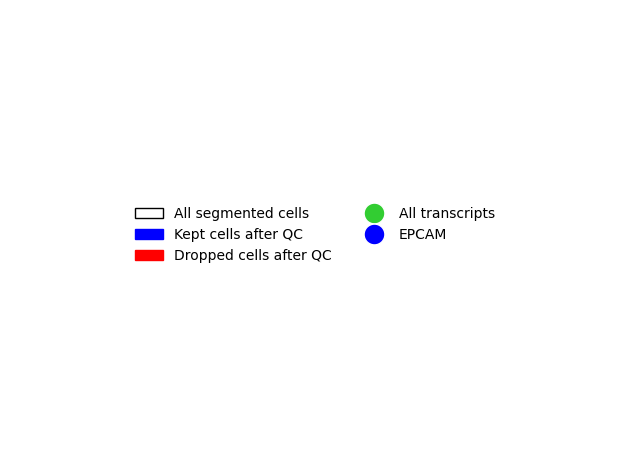

In [6]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt

gene = 'EPCAM'

legend_elements = [Patch(facecolor='none', edgecolor='black', label='All segmented cells'),
                   Patch(facecolor='Blue', edgecolor='Blue', label='Kept cells after QC'),
                   Patch(facecolor='Red', edgecolor='Red', label='Dropped cells after QC'),
                   Line2D([0], [0], marker='o', color='w', label='All transcripts', markerfacecolor='limegreen', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label=f'{gene}', markerfacecolor='blue', markersize=15),]

# Create the figure
fig, ax = plt.subplots()
legend = ax.legend(handles=legend_elements, loc='center', ncol=2)  # Set ncol to 3 for three columns

# Hide the frame of the legend
legend.set_frame_on(False)

plt.axis('off')
plt.tight_layout()
plt.show()
fig.savefig(f'{wd}/figures/segmentation_legend.png', format='png', dpi=500, transparent=True)
fig.savefig(f'{wd}/figures/segmentation_legend.eps', format='eps', dpi=500, transparent=True)
